1. Import Libraries and Set GPU Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Device setup (Check for GPU availability)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

# Check CUDA and GPU information
print(f"Is GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of available GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.get_device_name(0)}")


Current device: cuda
Is GPU available: True
CUDA version: 12.1
Number of available GPUs: 1
Current GPU: NVIDIA A100-SXM4-40GB


2. Path Extraction Module

In [2]:
def extract_2d_scan_paths(x):
    """
    Extracts 4 scanning paths (left-to-right, right-to-left, top-to-bottom, bottom-to-top) from a 2D image.
    Args:
        x (torch.Tensor): Input 2D image, shape (B, C, H, W)
    Returns:
        list of torch.Tensor: 4 scanning paths, each with shape (B, C, H*W)
    """
    B, C, H, W = x.shape
    left_to_right = x.view(B, C, H * W)
    right_to_left = x.flip(dims=[-1]).view(B, C, H * W)
    top_to_bottom = x.permute(0, 1, 3, 2).contiguous().view(B, C, W * H)
    bottom_to_top = x.permute(0, 1, 3, 2).flip(dims=[-1]).contiguous().view(B, C, W * H)
    return [left_to_right, right_to_left, top_to_bottom, bottom_to_top]


3. S6 Module Definition

In [3]:
class S6(nn.Module):
    def __init__(self, in_channels):
        """
        S6 module for selective scan operation.
        Args:
            in_channels (int): Number of input channels
        """
        super(S6, self).__init__()
        self.linear = nn.Linear(in_channels, in_channels)

    def forward(self, x):
        """
        Forward pass of the S6 module.
        """
        return self.linear(x)


4. SS2D Module Implementation

In [4]:
class SS2D(nn.Module):
    def __init__(self, s6_block):
        """
        2D Selective Scan module.
        Args:
            s6_block: Function to create an S6 block for each scan path.
        """
        super(SS2D, self).__init__()
        self.s6_blocks = nn.ModuleList([s6_block() for _ in range(4)])

    def forward(self, x):
        # Extract 2D scan paths
        B, C, H, W = x.shape
        left_to_right = x.view(B, C, H * W)
        right_to_left = x.flip(dims=[-1]).view(B, C, H * W)
        top_to_bottom = x.permute(0, 1, 3, 2).contiguous().view(B, C, W * H)
        bottom_to_top = x.permute(0, 1, 3, 2).flip(dims=[-1]).contiguous().view(B, C, W * H)

        # Apply S6 blocks to each path
        scan_paths = [left_to_right, right_to_left, top_to_bottom, bottom_to_top]
        # print(f"Scan paths shapes: {[path.shape for path in scan_paths]}")
        scanned_paths = [self.s6_blocks[i](scan_paths[i]) for i in range(4)]
        # print(f"Scanned paths shapes: {[path.shape for path in scanned_paths]}")

        # Combine paths
        combined = torch.stack(scanned_paths, dim=-1).mean(dim=-1)
        # print(f"Combined shape: {combined.shape}")

        # Reshape back to original shape
        return combined.view(B, C, H, W)



5. VSSBlock Implementation

In [5]:
class VSSBlock(nn.Module):
    def __init__(self, in_channels, out_channels, s6_block):
        """
        VSS block with selective scan integration.
        """
        super(VSSBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

        # Add Selective Scan
        self.ss2d = SS2D(s6_block)

        # Channel adjustment layer
        self.channel_adjust = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # print(f"Input to VSSBlock: {x.shape}")
        x = self.conv1(x)
        # print(f"After conv1: {x.shape}")
        x = self.norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        # print(f"After conv2: {x.shape}")
        x = self.norm2(x)
        x = self.activation(x)

        # Apply selective scan
        x = self.ss2d(x)
        # print(f"After selective scan: {x.shape}")

        # Apply channel adjustment
        x = self.channel_adjust(x)
        # print(f"After channel adjustment: {x.shape}")
        return x



6. VMamba Backbone Implementation

In [6]:
import torch
import torch.nn as nn

class VMamba(nn.Module):
    def __init__(self, in_channels, num_blocks, s6_block):
        """
        VMamba backbone with complete logic reconstruction.
        Args:
            in_channels (int): Number of input channels (e.g., 3 for RGB images).
            num_blocks (int): Number of VSS blocks.
            s6_block: Function to create an S6 block.
        """
        super(VMamba, self).__init__()

        # Initial convolution layer
        self.stem = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        print("Stem initialized successfully.")

        # Stack of VSS blocks
        blocks = []
        current_channels = 32
        for _ in range(num_blocks):
            next_channels = current_channels * 2  # Double the channels at each block
            blocks.append(VSSBlock(current_channels, next_channels, s6_block))
            current_channels = next_channels
        self.blocks = nn.Sequential(*blocks)
        print("Blocks initialized successfully.")

        # Save final number of channels
        self.final_channels = current_channels
        print(f"Final channels after blocks: {self.final_channels}")

        # Adaptive average pooling to reduce (H, W) to (1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Placeholder for classification head
        self.head = None

    def forward(self, x):
        """
        Forward pass of the VMamba model.
        """
        # print(f"Input to stem: {x.shape}")
        x = self.stem(x)
        # print(f"Output of stem: {x.shape}")

        x = self.blocks(x)
        # print(f"Output of blocks: {x.shape}")

        # Apply global average pooling
        x = self.global_pool(x)  # Shape: (batch_size, channels, 1, 1)
        # print(f"After global average pooling: {x.shape}")

        # Flatten pooled output to (batch_size, channels)
        x = x.view(x.size(0), -1)
        # print(f"After flattening: {x.shape}")

        # Dynamically initialize classification head
        if self.head is None:
            self.head = nn.Linear(self.final_channels, 10).to(x.device)  # CIFAR-10 has 10 classes
            # print(f"Head initialized with input features: {self.final_channels}")

        x = self.head(x)
        # print(f"Output of head: {x.shape}")
        return x




7. Training Script

In [7]:
# Load data
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VMamba(in_channels=3, num_blocks=4, s6_block=lambda: nn.Identity()).to(device)

# Validate the forward propagation
for inputs, labels in trainloader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    break


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Stem initialized successfully.
Blocks initialized successfully.
Final channels after blocks: 512


**TEST**

Files already downloaded and verified


Epoch 1/20: 100%|██████████| 391/391 [00:36<00:00, 10.75it/s]

Epoch 1 Loss: 1.4993


Validation Accuracy after Epoch 1: 46.60%


Epoch 2/20: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Epoch 2 Loss: 1.3331


Validation Accuracy after Epoch 2: 48.71%


Epoch 3/20: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]

Epoch 3 Loss: 1.2234


Validation Accuracy after Epoch 3: 53.07%


Epoch 4/20: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Epoch 4 Loss: 1.1407


Validation Accuracy after Epoch 4: 50.25%


Epoch 5/20: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]

Epoch 5 Loss: 1.0843


Validation Accuracy after Epoch 5: 53.68%


Epoch 6/20: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Epoch 6 Loss: 1.0446


Validation Accuracy after Epoch 6: 55.17%


Epoch 7/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 7 Loss: 1.0017


Validation Accuracy after Epoch 7: 58.68%


Epoch 8/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 8 Loss: 0.9723


Validation Accuracy after Epoch 8: 57.19%


Epoch 9/20: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Epoch 9 Loss: 0.9437


Validation Accuracy after Epoch 9: 59.93%


Epoch 10/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 10 Loss: 0.9244


Validation Accuracy after Epoch 10: 61.89%


Epoch 11/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 11 Loss: 0.9012


Validation Accuracy after Epoch 11: 61.22%


Epoch 12/20: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Epoch 12 Loss: 0.8740


Validation Accuracy after Epoch 12: 63.41%


Epoch 13/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 13 Loss: 0.8620


Validation Accuracy after Epoch 13: 61.25%


Epoch 14/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 14 Loss: 0.8428


Validation Accuracy after Epoch 14: 62.37%


Epoch 15/20: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]

Epoch 15 Loss: 0.8317


Validation Accuracy after Epoch 15: 50.71%


Epoch 16/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 16 Loss: 0.8080


Validation Accuracy after Epoch 16: 69.12%


Epoch 17/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 17 Loss: 0.8031


Validation Accuracy after Epoch 17: 63.76%


Epoch 18/20: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]

Epoch 18 Loss: 0.7793


Validation Accuracy after Epoch 18: 68.74%


Epoch 19/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 19 Loss: 0.7735


Validation Accuracy after Epoch 19: 71.57%


Epoch 20/20: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]

Epoch 20 Loss: 0.7608


Validation Accuracy after Epoch 20: 67.21%
Training complete!


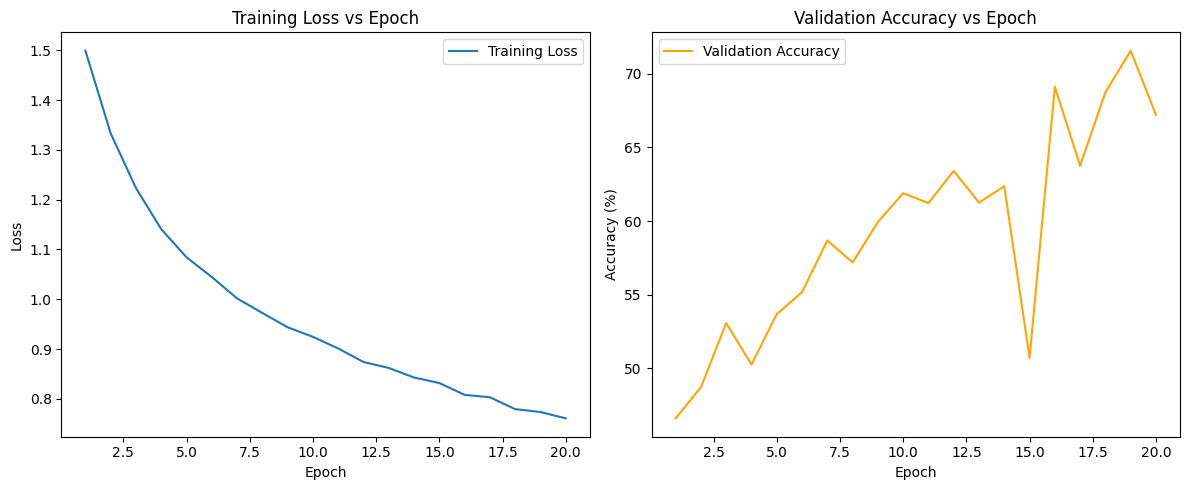

In [10]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CIFAR-10 testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Begin training
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Training
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Gradient reset
        outputs = model(inputs)  # forward propagation
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # back propagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss / len(trainloader):.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

print("Training complete!")


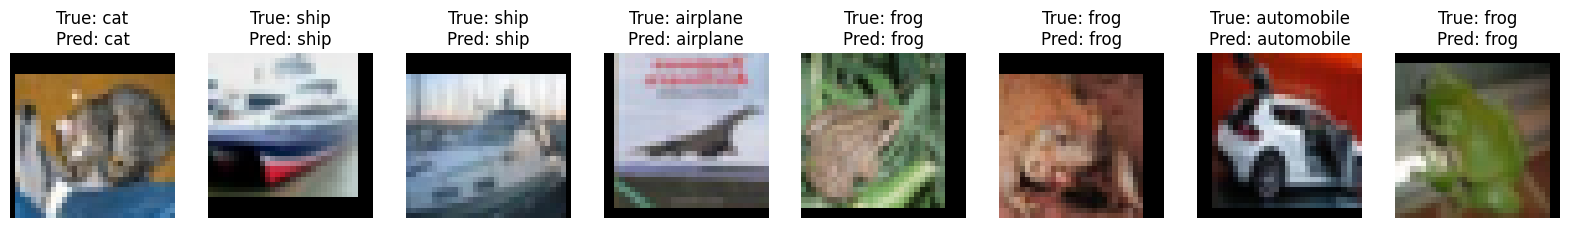

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, classes):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move data to CPU for visualization
    images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()

    # Show first 8 predictions
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))
    for i in range(8):
        ax = axes[i]
        ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5)  # Unnormalize
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        ax.axis('off')
    plt.show()

# Call the function after training
classes = trainset.classes
show_predictions(model, testloader, classes)